In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
import logging
import random
import textwrap
import itertools
from tqdm.auto import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.spatial.distance import cdist

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel

from sentiment_analysis.config import SentimentAnalysisConfig
from sentiment_analysis.data_access import DataClass
from sentiment_analysis.features import Features
from sentiment_analysis.evaluation import CustomEvaluation
from sentiment_analysis.utils.constants import (
    TEXT,
    TARGET,
    ORIGINAL_TEXT,
    SPLIT,
    TRAIN,
    VALID,
    TEST,
    SAVED_MODELS,
    PREDICTION
)

device = "cuda" if torch.cuda.is_available() else "cpu"
sns.set_style("darkgrid")
PARENT_PATH = Path(os.getcwd()).parent.absolute()
FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)

seed = 128
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed);

In [3]:
config = SentimentAnalysisConfig()
config.CURRENT_PATH = PARENT_PATH

data = DataClass(config)
df = data.build()
df.head(10)

2022-12-08 04:16:09,024 - sentiment_analysis.utils.utils - INFO - func:build took: 1.41 sec


,review,sentiment,Split
0,how can a director that makes such great films...,neg,development
1,This is one of the worst film adaptations of a...,neg,development
2,This is an art film that was either made in 19...,neg,development
3,"For two of the funniest comedians, the movie w...",neg,development
4,Doris Day never lets a bad script get her down...,neg,development
5,Unwatchable. You can't even make it past the f...,neg,development
6,"Quite average even by Monogram standards, this...",neg,development
7,This is not a good movie. Too preachy in parts...,neg,development
8,I am really shocked that a great director like...,neg,development
9,This is one of the weakest soft porn film arou...,neg,development


In [4]:
features = Features()
df_features = features.build(df)

2022-12-08 04:17:26,233 - sentiment_analysis.utils.utils - INFO - func:clean took: 1 min and                 16.95 sec
2022-12-08 04:17:44,368 - sentiment_analysis.utils.utils - INFO - func:fit took: 18.11 sec
2022-12-08 04:18:00,623 - sentiment_analysis.utils.utils - INFO - func:transform took: 16.25 sec
2022-12-08 04:18:00,624 - sentiment_analysis.utils.utils - INFO - func:fit_transform took: 34.37 sec
2022-12-08 04:18:02,346 - sentiment_analysis.utils.utils - INFO - func:transform took: 1.72 sec
2022-12-08 04:18:20,082 - sentiment_analysis.utils.utils - INFO - func:transform took: 17.74 sec
2022-12-08 04:18:21,800 - sentiment_analysis.utils.utils - INFO - func:build took: 2 min and                 12.53 sec


In [5]:
df_features.head(3)

,review,sentiment,Split,Original Text,char__ 00,char__ 1,char__ 10,char__ 11,char__ 12,char__ 13,...,word__york city,word__youll see,word__young boy,word__young girl,word__young man,word__young woman,word__youre going,word__youre looking,word__youve got,word__youve seen
0,saw movie tv afternoon cant see anyone sit pie...,0,train,I saw this movie on t.v. this afternoon and I ...,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,film true historical film useful researching l...,1,train,This film is a true and historical film. It is...,0.0,0.0,0.05085,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,film something like sequel white zombie since ...,0,train,"This film is something like a sequel of ""White...",0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Prepare data for training and validation

In [6]:
train = df_features[df_features[SPLIT].isin([TRAIN])].copy()
valid = df_features[df_features[SPLIT].isin([VALID])].copy()
train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)

X_train = train[features.vectorizer.get_feature_names_out()].copy()
X_valid = valid[features.vectorizer.get_feature_names_out()].copy()
Y_train = train[TARGET]
Y_valid = valid[TARGET]

pos_prob_train = sum(Y_train) / len(Y_train)
pos_prob_valid = sum(Y_train) / len(Y_train)
print(f"Number of features: {X_train.shape[1]:,}")
print(f"Number of training samples: {X_train.shape[0]:,}")
print(f"Training set label distribution: pos:{pos_prob_train:0.2f}, neg:{1-pos_prob_train:0.2f}")
print(f"Number of validation samples: {X_valid.shape[0]:,}")
print(f"Validation set label distribution: pos:{pos_prob_valid:0.2f}, neg:{1-pos_prob_valid:0.2f}")

Number of features: 5,000
Number of training samples: 22,500
Training set label distribution: pos:0.50, neg:0.50
Number of validation samples: 2,500
Validation set label distribution: pos:0.50, neg:0.50


Define custom dataset

In [7]:
class CustomDataset(Dataset):
    def __init__(
        self,
        data: pd.DataFrame,
        model_name: str,
        max_length: int = 128
    ):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.data = data
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        row = self.data.iloc[index]
        text = row[ORIGINAL_TEXT]
        target = np.array(row[TARGET]).reshape(-1,)
        inputs = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=self.max_length,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_token_type_ids=True,
        return_tensors='pt'
        )

        return {
            "text": text,
            "input_ids": inputs["input_ids"].flatten(),
            "attention_mask": inputs["attention_mask"].flatten(),
            "token_type_ids": inputs["token_type_ids"].flatten(),
            "target": torch.FloatTensor(target)
        }

Define the pre-trained model with classifier head

In [8]:
class Model(nn.Module):
    def __init__(self, model_name: str):
        super().__init__()
        self.l1 = AutoModel.from_pretrained(model_name)
        self.l2 = nn.Dropout(0.3)
        self.l3 = nn.Linear(self.l1.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask, token_type_ids):
        out = self.l1(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        out = self.l2(out.pooler_output)
        out = self.l3(out)
        return out

Choose model and load the tokenizer

In [9]:
MODEL_NAME = 'roberta-base'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

Token-length analysis based on tokenizer

This is important in deciding `MAX_TOKEN_COUNT`

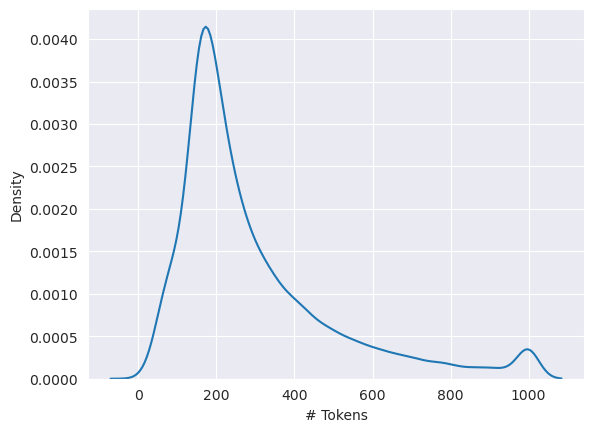

In [10]:
token_counts = []
for _, row in train.iterrows():
    tokens = tokenizer.encode(
        row[ORIGINAL_TEXT],
        max_length=1000,
        truncation=True
    )
    token_counts.append(len(tokens))
sns.kdeplot(token_counts)
plt.xlabel("# Tokens")
plt.ylabel("Density")
plt.show();

Initialize model with pre-trained weights

In [11]:
model = Model(MODEL_NAME)
model.to(device);

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Define hyper-parameters, choose criterion, optimizer

In [12]:
MAX_TOKEN_COUNT = 256
TRAIN_BATCH = 32
VALID_BATCH_SIZE = 32
EPOCHS = 5
LEARNING_RATE = 1e-05
NUM_WORKERS = 0

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)
saved_models_path = Path(os.path.join(data.current_path, SAVED_MODELS))
saved_models_path.mkdir(parents=True, exist_ok=True)

Build dataloaders

In [13]:
train_dataset = CustomDataset(
    train,
    MODEL_NAME,
    max_length=MAX_TOKEN_COUNT
)
valid_dataset = CustomDataset(
    valid,
    MODEL_NAME,
    max_length=MAX_TOKEN_COUNT
)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=TRAIN_BATCH, num_workers=NUM_WORKERS)
valid_loader = DataLoader(valid_dataset, shuffle=False, batch_size=VALID_BATCH_SIZE, num_workers=NUM_WORKERS)

Train

In [14]:
# Move model to device
model.to(device)
# Lists to keep the losses and evaluation scores at the end of each epoch
train_loss, valid_loss = list(), list()
for epoch in range(EPOCHS):
    # Dummy lists to keep the losses and evaluation scores at the end of each iteration
    # (one batch forward and backward process)
    train_batch_loss, valid_batch_loss = list(), list()
    # Training mode
    model.train()
    for i, item in enumerate(train_loader):
        # Move input to device
        input_ids = item["input_ids"].to(device, dtype=torch.long)
        attention_mask = item["attention_mask"].to(device, dtype=torch.long)
        token_type_ids = item["token_type_ids"].to(device, dtype=torch.long)
        target = item["target"].to(device, dtype=torch.float)
        # Forward pass
        out = model(input_ids, attention_mask, token_type_ids)
        # Calculate loss
        loss = criterion(out, target)
        # Reset gradients
        optimizer.zero_grad()
        # Backward pass (backpropogation)
        loss.backward()
        # Update weights
        optimizer.step()
        # Collect loss and evaluation scores
        train_batch_loss.append(loss.item())
        message = \
            f"EPOCH:{epoch+1}/{EPOCHS}, " + \
            f"step:{i+1}/{len(train_loader)}, " + \
            f"loss={loss.item()}"
        print("\r", message, end="")
    # Take the average of iteration losses and evaluation scores
    # and append it to the epoch losses list
    train_loss.append(np.array(train_batch_loss).mean())
    # Evaluation mode
    model.eval()
    with torch.no_grad():
        for i, item in enumerate(valid_loader):
            # Move input to device
            input_ids = item["input_ids"].to(device, dtype=torch.long)
            attention_mask = item["attention_mask"].to(device, dtype=torch.long)
            token_type_ids = item["token_type_ids"].to(device, dtype=torch.long)
            target = item["target"].to(device, dtype=torch.float)
            # Forward pass
            out = model(input_ids, attention_mask, token_type_ids)
            # Calculate loss
            loss = criterion(out, target)
            valid_batch_loss.append(loss.item())
            message = \
                f"EPOCH:{epoch+1}/{EPOCHS}, " + \
                f"step:{i+1}/{len(valid_loader)}, " + \
                f"loss={loss.item()}"
            print("\r", message, end="")
    # Take the average of iteration losses and evaluation scores
    # and append it to the epoch losses list
    valid_loss.append(np.array(valid_batch_loss).mean())
    message = \
        f"EPOCH:{epoch+1}/{EPOCHS} - " + \
        f"Training Loss: {train_loss[-1]}, " + \
        f"Validation Loss: {valid_loss[-1]}"
    print("\r", message)
    # Save model
    state = f"epoch_{epoch+1:03}.pth"
    state_dict_path = os.path.join(saved_models_path, state)
    torch.save(model.state_dict(), state_dict_path)

 EPOCH:1/5 - Training Loss: 0.25525704875128047, Validation Loss: 0.16634687253191502
 EPOCH:2/5 - Training Loss: 0.1561605899584141, Validation Loss: 0.15870050156984147
 EPOCH:3/5 - Training Loss: 0.1074262951832762, Validation Loss: 0.17871256630066074
 EPOCH:4/5 - Training Loss: 0.06986354240838079, Validation Loss: 0.21168986761565262
 EPOCH:5/5 - Training Loss: 0.04734807147790641, Validation Loss: 0.20945127344324807


In [15]:
best_epoch = np.argmin(valid_loss) + 1
print(f"Best epoch: {best_epoch}")
state = f"epoch_{best_epoch:03}.pth"
state_dict_path = os.path.join(saved_models_path, state)
state_dict = torch.load(state_dict_path)
model.load_state_dict(state_dict)
model.to(device)
model.eval();

Best epoch: 2


In [16]:
best_epoch = np.argmin(valid_loss) + 1
print(f"Best epoch: {best_epoch}")
state = f"epoch_{best_epoch:03}.pth"
state_dict_path = os.path.join(saved_models_path, state)
state_dict = torch.load(state_dict_path)
model.load_state_dict(state_dict)
model.to(device)
model.eval();

Best epoch: 2


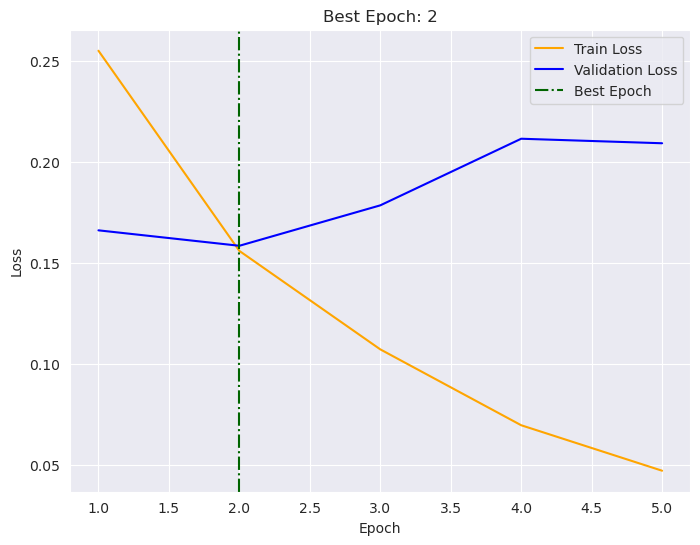

In [17]:
fig = plt.figure(figsize=(8, 6))
plt.plot(range(1, EPOCHS+1), train_loss, label="Train Loss", color="orange")
plt.plot(range(1, EPOCHS+1), valid_loss, label="Validation Loss", color="blue")
plt.axvline(x=best_epoch, label="Best Epoch", color="darkgreen", linestyle="dashdot")
plt.xlabel("Epoch")
plt.ylabel(f"Loss")
plt.title(f"Best Epoch: {best_epoch}")
plt.legend(loc="upper right");

Evaluation

In [18]:
eval = CustomEvaluation()

In [19]:
valid_dataset = CustomDataset(
    valid,
    MODEL_NAME,
    max_length=MAX_TOKEN_COUNT
)
valid_loader = DataLoader(valid_dataset, shuffle=False, batch_size=1, num_workers=NUM_WORKERS)

y_true = []
y_pred_probab = []
with torch.no_grad():
    for i, item in enumerate(valid_loader):
        input_ids = item["input_ids"].to(device, dtype=torch.long)
        attention_mask = item["attention_mask"].to(device, dtype=torch.long)
        token_type_ids = item["token_type_ids"].to(device, dtype=torch.long)
        target = item["target"].to(device, dtype=torch.float)

        out = model(input_ids, attention_mask, token_type_ids)
        out = torch.sigmoid(out)

        y_true.append(target.to("cpu").numpy().reshape(-1,))
        y_pred_probab.append(out.to("cpu").numpy().reshape(-1,))

y_true_val = np.array(y_true).astype(int)
y_pred_probab_val = np.array(y_pred_probab)

Score on validation set

In [20]:
y_pred_val = np.where(y_pred_probab_val > .5, 1, 0)

eval.evaluate(y_true=y_true_val, y_pred=y_pred_val)

Accuracy     0.936000
Precision    0.921766
Recall       0.952762
F1 Score     0.937008
dtype: float64

Score on test set

In [21]:
test = df_features[df_features[SPLIT].isin([TEST])].copy()
test.reset_index(drop=True, inplace=True)

test_dataset = CustomDataset(
    test,
    MODEL_NAME,
    max_length=MAX_TOKEN_COUNT
)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=1, num_workers=NUM_WORKERS)

y_true = []
y_pred_probab = []

with torch.no_grad():
    for i, item in enumerate(test_loader):
        input_ids = item["input_ids"].to(device, dtype=torch.long)
        attention_mask = item["attention_mask"].to(device, dtype=torch.long)
        token_type_ids = item["token_type_ids"].to(device, dtype=torch.long)
        target = item["target"].to(device, dtype=torch.float)

        out = model(input_ids, attention_mask, token_type_ids)
        out = torch.sigmoid(out)

        y_true.append(target.to("cpu").numpy().reshape(-1,))
        y_pred_probab.append(out.to("cpu").numpy().reshape(-1,))

y_true_test = np.array(y_true).astype(int)
y_pred_probab_test = np.array(y_pred_probab)


In [22]:
y_pred_test = np.where(y_pred_probab_test > .5, 1, 0)

eval.evaluate(y_true=y_true_test, y_pred=y_pred_test)

Accuracy     0.939920
Precision    0.923848
Recall       0.958880
F1 Score     0.941038
dtype: float64

Save predictions

In [23]:
pred_df = test[[ORIGINAL_TEXT, TARGET]].copy()
pred_df[PREDICTION] = y_pred_test.reshape(-1,)
save_to = os.path.join(data.reports_path, "roberta-prediction.pkl")
pred_df.to_pickle(save_to)

Evaluate embeddings

Extract embeddings for test reviews from fine-tuned model

In [24]:
# Reduce to test set
df_features = df_features[df_features[SPLIT].isin([TEST])].copy()
df_features.reset_index(drop=True, inplace=True)

dataset = CustomDataset(
    df_features,
    MODEL_NAME,
    max_length=MAX_TOKEN_COUNT
)
dataset_loader = DataLoader(dataset, shuffle=False, batch_size=1, num_workers=NUM_WORKERS)

y_true = []
reviews = []
embeddings = []
with torch.no_grad():
    for i, item in enumerate(dataset_loader):
        reviews.append(item["text"])
        input_ids = item["input_ids"].to(device, dtype=torch.long)
        attention_mask = item["attention_mask"].to(device, dtype=torch.long)
        token_type_ids = item["token_type_ids"].to(device, dtype=torch.long)
        target = item["target"].to(device, dtype=torch.float)

        out = model.l1(input_ids, attention_mask, token_type_ids)
        embeddings.append(out.pooler_output.to("cpu").numpy().reshape(-1,))
        y_true.append(target.to("cpu").numpy().reshape(-1,))

y_true = np.array(y_true).astype(int)
reviews = ["<br>".join((textwrap.wrap(x[0]))) for x in reviews]
embeddings = np.array(embeddings)

k-Means (Floyd)

In [25]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 5)

for k in tqdm(K):
    # Building and fitting the model
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeanModel = kmeans.fit(embeddings)
    distortions.append(
        sum(np.min(
            cdist(embeddings, kmeanModel.cluster_centers_, 'euclidean'),
            axis=1
        )) / embeddings.shape[0]
    )
    inertias.append(kmeanModel.inertia_)
    mapping1[k] = sum(np.min(
        cdist(embeddings, kmeanModel.cluster_centers_, 'euclidean'),
        axis=1
    )) / embeddings.shape[0]
    mapping2[k] = kmeanModel.inertia_

  0%|          | 0/4 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


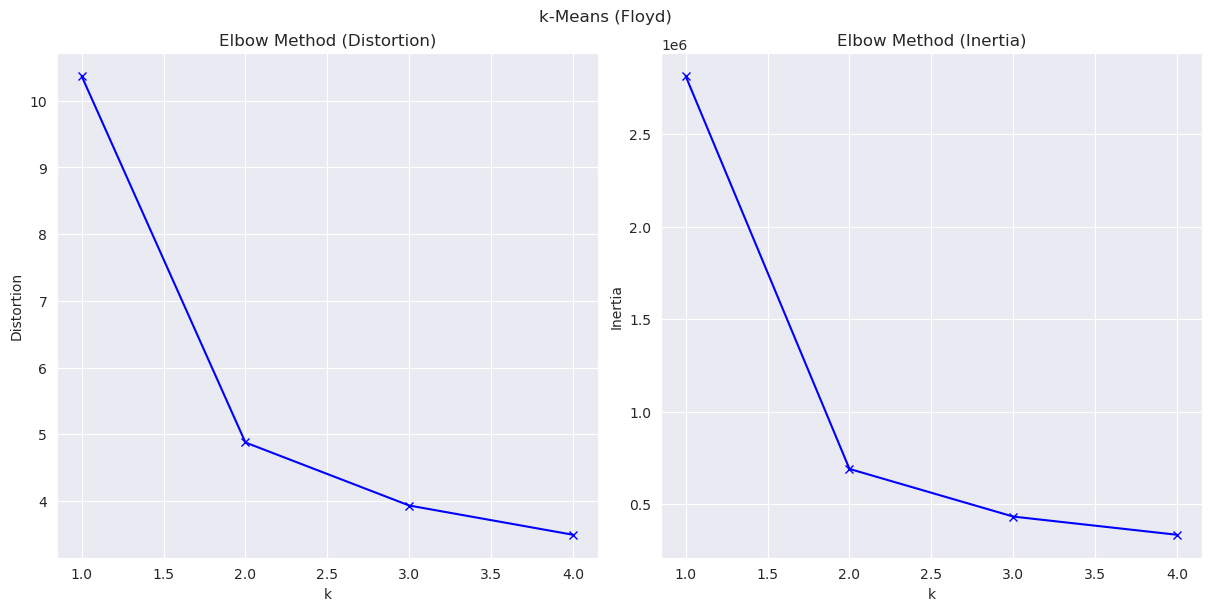

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(12,6), constrained_layout=True)
ax[0].plot(K, distortions, 'bx-')
ax[0].set_xlabel('k')
ax[0].set_ylabel('Distortion')
ax[0].set_title('Elbow Method (Distortion)')
ax[1].plot(K, inertias, 'bx-')
ax[1].set_xlabel('k')
ax[1].set_ylabel('Inertia')
ax[1].set_title('Elbow Method (Inertia)')
fig.suptitle("k-Means (Floyd)");

Elbow method suggests $k=2$

In [27]:
# Useful constants
EMBEDDINGS = ["llm_{i}" for i in range(model.l1.config.hidden_size)]
CLUSTER = "cluster"
SENTIMENT = "Sentiment"
sentiment_map_inverse = {config.SENTIMENT_MAP[c]: c for c in config.SENTIMENT_MAP}

# Utility functions to compute purity of clusters
def compute_purity(df):
    purity_scores = {}
    clusters_unique = df[CLUSTER].unique()
    for c in clusters_unique:
        labels = df[df[CLUSTER]==c][TARGET].tolist()
        sorted_labels = sorted(list(set(labels)), key=labels.count, reverse=True)
        mode = sorted_labels[0]
        score = sum([1 if y==mode else 0 for y in labels]) / len(labels)
        mode_label = sentiment_map_inverse[mode]
        purity_scores[c] = (score, mode_label)
    return purity_scores

In [28]:
k = 2
clustering_method = KMeans(n_clusters=k, random_state=0)
clusters = clustering_method.fit(embeddings)

embeddings_df = pd.DataFrame(embeddings, columns=EMBEDDINGS)
embeddings_df[ORIGINAL_TEXT] = reviews
embeddings_df[CLUSTER] = clusters.labels_
embeddings_df[TARGET] = y_true.reshape(-1,)
embeddings_df[SENTIMENT] = embeddings_df[TARGET].apply(lambda x: sentiment_map_inverse[x])

scores = compute_purity(embeddings_df)
scores

{0: (0.9560931157319195, 'neg'), 1: (0.9258256632376828, 'pos')}

In [30]:
dim_reduction_method = TSNE(n_components=2, init="pca", learning_rate="auto")
embeddings_reduced = dim_reduction_method.fit_transform(embeddings)

embeddings_df["x"] = embeddings_reduced[:,0]
embeddings_df["y"] = embeddings_reduced[:,1]

/home/vtyagi/miniconda3/envs/sentiment-analysis/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


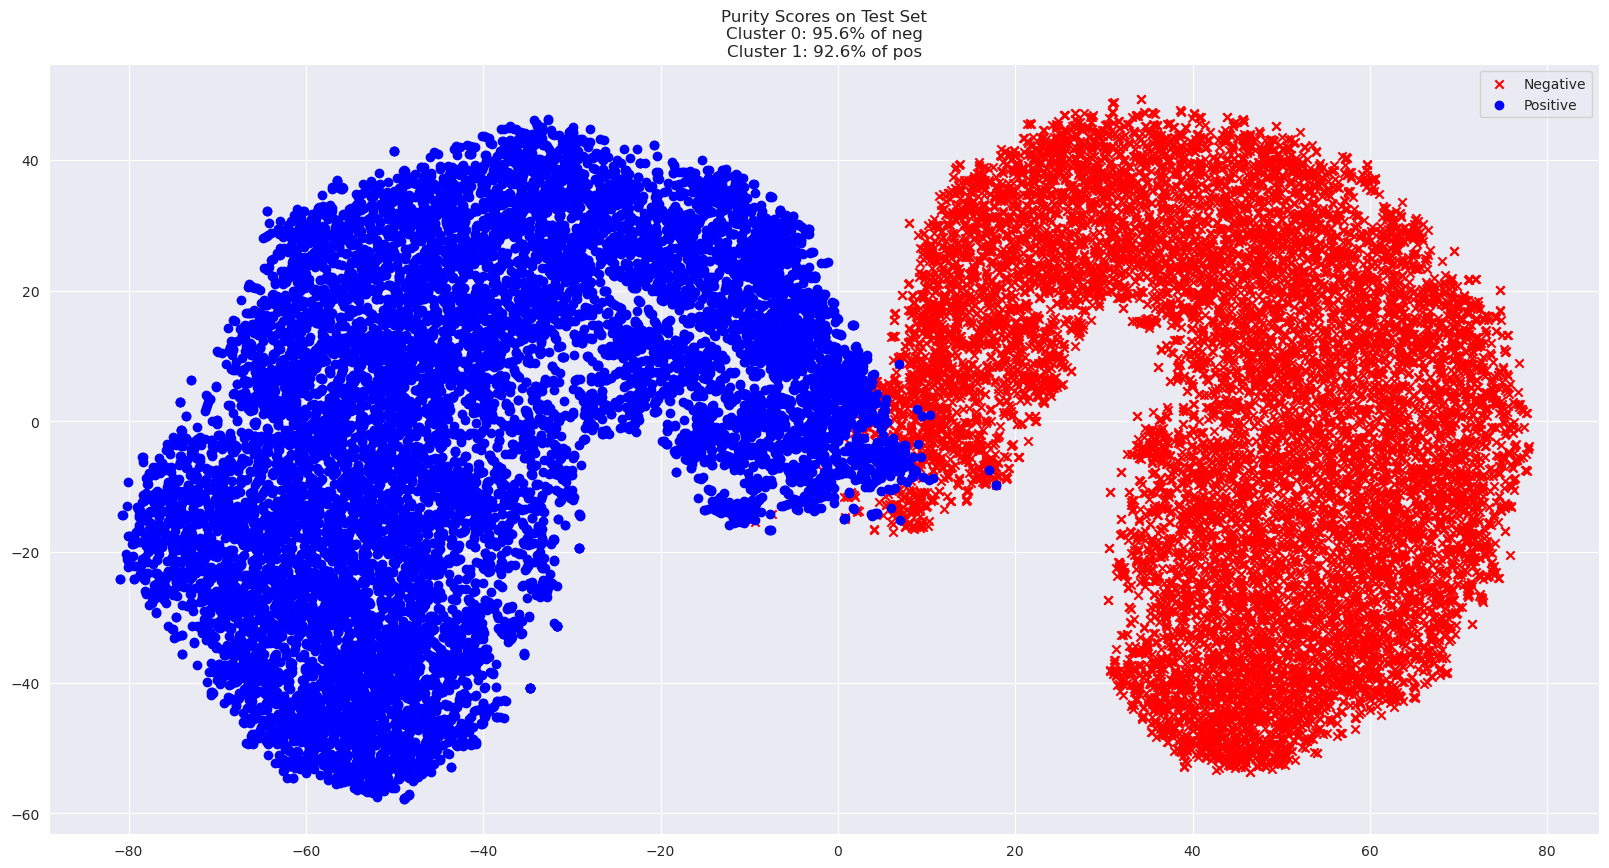

In [73]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.scatter(
    data=embeddings_df[embeddings_df[CLUSTER]==0],
    x="x",
    y="y",
    color="red",
    label="Negative",
    marker="x"
)
plt.scatter(
    data=embeddings_df[embeddings_df[CLUSTER]==1],
    x="x",
    y="y",
    color="blue",
    label="Positive",
    marker="o"
)
plt.title(f"Purity Scores on Test Set\nCluster 0: {scores[0][0]*100:.3}% of {scores[0][1]}\nCluster 1: {scores[1][0]*100:.3}% of {scores[1][1]}")
plt.legend();

In [ ]:
fig = px.scatter(
    embeddings_df,
    y="y",
    x="x",
    color=CLUSTER,
    symbol=,
    hover_data=[TARGET, ORIGINAL_TEXT],
    title="k-Means"
)
fig.update_layout(uniformtext_mode="hide")
fig.update_layout(legend_orientation="h")
fig.show()